In [7]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)

TF version: 2.10.1
TFP version: 0.18.0


# Probabilistic layers and Bayesian neural networks

## Coding tutorials
#### [1. The DistributionLambda layer](#coding_tutorial_1)
#### [2. Probabilistic layers](#coding_tutorial_2)
#### [3. The DenseVariational layer](#coding_tutorial_3)
#### [4. Reparameterization layers](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## The `DistributionLambda` layer

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#### Create a probabilistic model using the `DistributionLambda` layer

Create a model whose first layer represents:

$$
y = \text{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.
$$

4/4 [==============================] - 0s 2ms/step


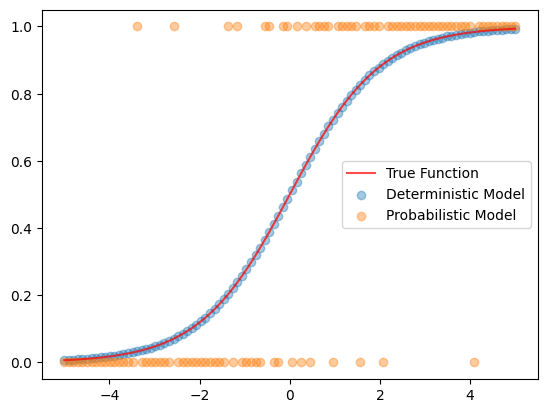

In [3]:
# Create a sigmoid model, first deterministic, then probabilistic

# deterministic model
model_d = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
          kernel_initializer=tf.constant_initializer(1), # initialize weights to 1
          bias_initializer=tf.constant_initializer(0)), # initialize biases to 0
])

# probabilistic model (Bernoulli distribution)
model_p = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
          kernel_initializer=tf.constant_initializer(1), # initialize weights to 1
          bias_initializer=tf.constant_initializer(0)), # initialize biases to 0
    tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs=t), # use discrete Bernoulli distribution with probs=1 being defined by "t" i.e. output of previous layer
                            convert_to_tensor_fn=tfd.Distribution.sample) # sample from (or could also try mean) the Bernoulli distribution and convert it to tensor instead of outputting distribution object
])

# Plot the function
x_plot = np.linspace(-5, 5, 100)
plt.plot(x_plot, 1/(1 + np.exp(-x_plot)), color='r', alpha=0.7, label='True Function')
plt.scatter(x_plot, model_d.predict(x_plot), alpha=0.4, label='Deterministic Model')
plt.scatter(x_plot, model_p.predict(x_plot), alpha=0.4, label='Probabilistic Model')
plt.legend()
plt.show()

In [4]:
# Create a constant input for this model
x = np.array([[0]])
x

array([[0]])

In [5]:
# Explore the feedforward object...
y_model_d = model_d(x)
y_model_d

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5]], dtype=float32)>

In [6]:
# Explore the feedforward object...
y_model_p = model_p(x)
y_model_p

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1, 1] event_shape=[] dtype=int32>

In [7]:
# ... and its behaviour under repeated calls
for _ in range(5):
    print(model_d.predict(x))

1/1 [==============================] - 0s 26ms/step
[[0.5]]
1/1 [==============================] - 0s 19ms/step
[[0.5]]
1/1 [==============================] - 0s 15ms/step
[[0.5]]
1/1 [==============================] - 0s 15ms/step
[[0.5]]
1/1 [==============================] - 0s 15ms/step
[[0.5]]


In [8]:
# ... and its behaviour under repeated calls
for _ in range(5):
    print(model_p.predict(x))

1/1 [==============================] - 0s 40ms/step
[[0]]
1/1 [==============================] - 0s 12ms/step
[[1]]
1/1 [==============================] - 0s 13ms/step
[[0]]
1/1 [==============================] - 0s 12ms/step
[[0]]
1/1 [==============================] - 0s 13ms/step
[[0]]


#### Use the forward model to create probabilistic training data

16/16 [==============================] - 0s 1ms/step


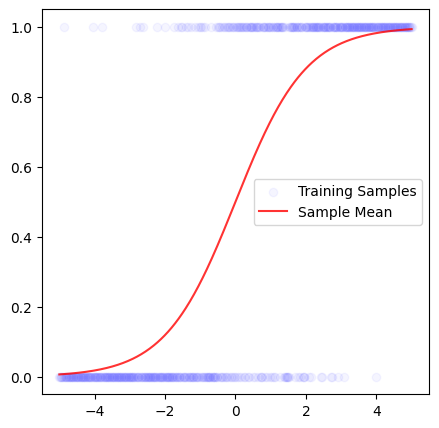

In [9]:
# Use the probabilistic model to create 500 training points
x_train = np.float32(np.linspace(-5, 5, 500)[:, np.newaxis])
y_train = model_p.predict(x_train)

# Plot the data and the mean of the distribution
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x_train, y_train, alpha=0.04, color='blue', label='Training Samples')
ax.plot(x_train, model_p(x_train).mean().numpy().flatten(), 
        color='red', alpha=0.8, label='Sample Mean')
ax.legend()
plt.show()

#### Create a new probabilistic model with the wrong weights

In [10]:
# Create a new version of the model, with the wrong (non-optimal) weights
model_untrained = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
          kernel_initializer=tf.constant_initializer(2), # initialize weights to 1
          bias_initializer=tf.constant_initializer(2)), # initialize biases to 0
    tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs=t), # use discrete Bernoulli distribution with probs=1 being defined by "t" i.e. output of previous layer
                            convert_to_tensor_fn=tfd.Distribution.sample) # sample from (or could also try mean) the Bernoulli distribution and convert it to tensor instead of outputting distribution object
])

#### Train the new model with the negative loglikelihood

In [11]:
# Define negative loglikelihood, which we will use for training
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)    

In [12]:
# Compile untrained model
model_untrained.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))

In [13]:
# Train model, record weights after each epoch
epochs = [0]
training_weights = [model_untrained.weights[0].numpy()[0, 0]]
training_bias = [model_untrained.weights[1].numpy()[0]]
for epoch in range(100):
    model_untrained.fit(x=x_train, y=y_train, epochs=1, verbose=False)
    epochs.append(epoch)
    training_weights.append(model_untrained.weights[0].numpy()[0, 0])
    training_bias.append(model_untrained.weights[1].numpy()[0])

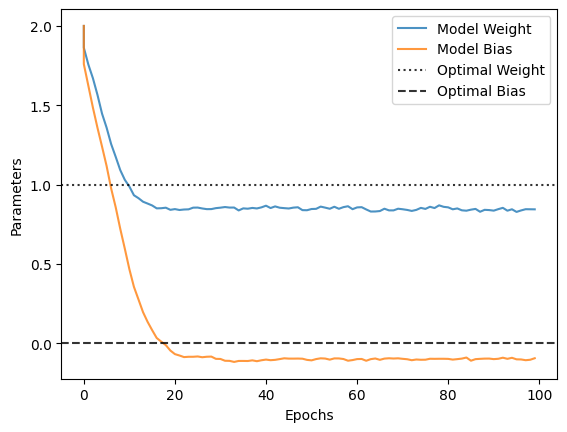

In [14]:
# Plot the model weights as they train, converging to the correct values
plt.plot(epochs, training_weights, alpha=0.8, label='Model Weight')
plt.plot(epochs, training_bias, alpha=0.8, label='Model Bias')
plt.axhline(y=1, label='Optimal Weight', color='k', linestyle=':', alpha=0.8)
plt.axhline(y=0, label='Optimal Bias', color='k', linestyle='--', alpha=0.8)
plt.xlabel('Epochs')
plt.ylabel('Parameters')
plt.legend()
plt.show()

The parameters don't exactly reach the "optimal values" owing to the epistemic uncertainty since the number of data samples is just 500.

***
<a id="coding_tutorial_2"></a>
## Probabilistic layers

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#### Create data

The data you'll be working with is artifically created from the following equation:
$$ y_i = x_i + \frac{3}{10}\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

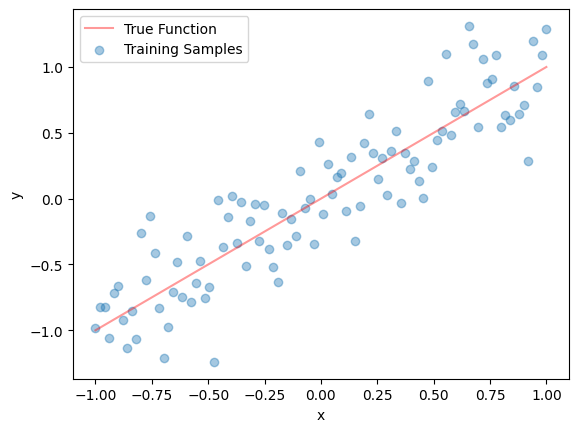

In [16]:
# Create and plot 100 points of training data
x_train = np.float32(np.linspace(-1, 1, 100)[:, np.newaxis])
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]

plt.plot(x_train, x_train, color='red', alpha=0.4, label='True Function')
plt.scatter(x_train, y_train, alpha=0.4, label='Training Samples')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Deterministic linear regression with MSE loss

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
4/4 [==============================] - 0s 2ms/step


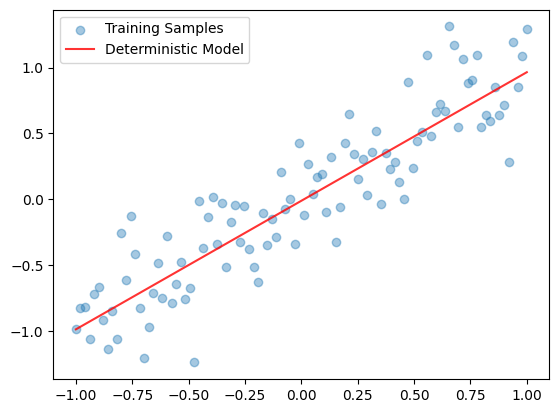

In [17]:
# Create and train deterministic linear model using mean squared error loss

# Create linear regression via Sequential model
model = Sequential([
    Dense(units=1, input_shape=(1,))
])
model.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model.summary()
model.fit(x_train, y_train, epochs=200, verbose=False)

# Plot the data and model
plt.scatter(x_train, y_train, alpha=0.4, label='Training Samples')
plt.plot(x_train, model.predict(x_train), color='red', alpha=0.8, label='Deterministic Model')
plt.legend()
plt.show()

In [18]:
# Examine the model predictions
x = np.array([[0]])
y_model = model(x)
y_model

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.01192663]], dtype=float32)>

We see while the output is just a Tensor and it's just a NumPy array, or the NumPy value is 0.06 (or whatever depending on the data). It says, well, if my x value is zero, I expect my y value to be pretty close to zero, a little bit above zero. But in reality, that doesn't really tell the whole story. If I actually try to predict where a new blue dot would be with x value 0, it probably wouldn't be exactly 0.06. There's some uncertainty. In fact, most of these blue dots don't lie on the red line. What this deterministic linear regression fails to capture is the `aleatoric uncertainty`, which says, even if I knew the x value and I knew the mean or the best fit of this regression, I wouldn't exactly know what the y value is because the y value doesn't actually always lie on this best-fit line, there's some uncertainty.

#### Probabilistic linear regression with both user-defined and learned variance

In [19]:
# Create probabilistic regression with normal distribution as final layer
model = Sequential([
    Dense(units=1, input_shape=(1,)),
    tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=t, scale=1))) # use Normal distribution with mean being defined by "t" i.e. output of previous layer and std. dev. being constant (i.e. 1)
])

model.summary()

Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1)                 2         
                                                                 
 distribution_lambda_2 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Train model using the negative loglikelihood

# Define negative loglikelihood, which we will use for training
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.fit(x_train, y_train, epochs=100, verbose=False)

In [21]:
# Examine the distribution created as a feedforward value
x = np.array([[0]])
y_model = model(x)
y_model

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[1] dtype=float32>

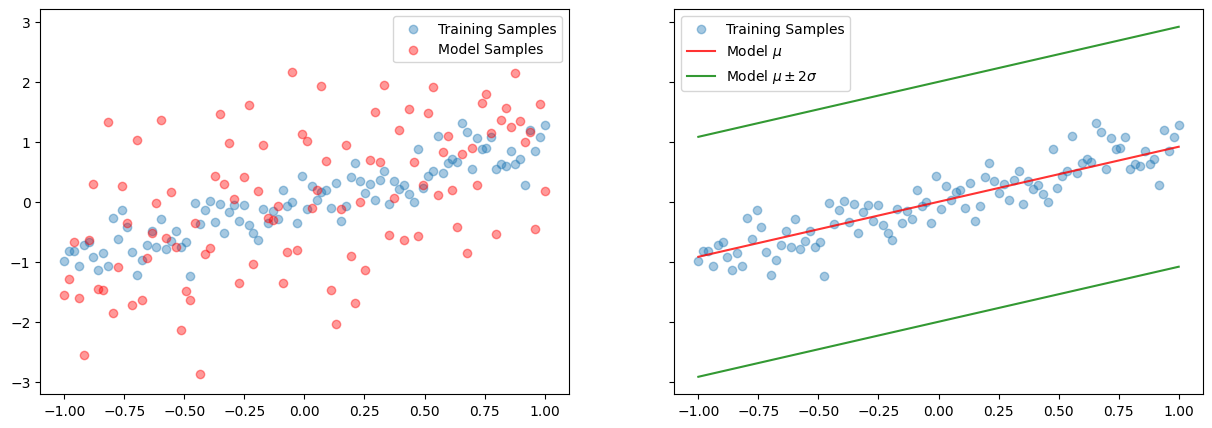

In [22]:
# Plot the data and a sample from the model
y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='Training Samples')
ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='Model Samples')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='Training Samples')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='Model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='Model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

The plot on the left shows the training data samples in blue. The red dots are samples with the same x values from the distribution, from essentially the learned model. Recall in the learned model, the output is a distribution, so we sample from it. The plot on the right shows some summary statistics for this learned distribution from the model. The red line shows the mean and the green lines show plus or minus 2 standard deviations. For normal distribution, which is exactly what we fit, we expect 95 percent samples from the distribution roughly to lie within two standard deviations. So we'd expect while we have 100 training points, 95 of them should lie within and five of them should lie outside, roughly. So the story of both of these plots is that while we've kind of learned the mean correctly, and recall that actually the mean, the red line is the same as the least squares estimator earlier, but it's too spread out. So the red dots, they seem like they can kind of have the right trend but they are way too spread out. So while this should have contained roughly just 95 percent samples, in reality, it's way too wide and covers like 100 percent (or more!). But this is not that surprising because if you see here what we did, well, we let `t` determine the mean, the location of this normal distribution. But we left the scale, which is the standard deviation at `1`, which is user-defined. Since we're doing machine learning, why don't we just learn also the standard deviation along with the mean, let's do  that.

In [23]:
# Create probabilistic regression with normal distribution as final layer
model = Sequential([
    Dense(units=1+1, input_shape=(1,)), # 1 input and 2 (1+1) outputs - 1 to parametrize mean and other to parametrize std. dev.
    tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal( # use Normal distribution with...
        loc=t[..., :1], # ...mean parametrized by first output of previous dense layer, the ellipsis (...) is for batch size
        scale=tf.math.softplus(t[..., 1:])))) # ...and std. dev. parametrized by second output of previous dense layer (softplus makes sure std. dev. is positive)
])

# More convenient way of writing the above model
event_shape = 1 # univariate distribution
model = Sequential([
    Dense(units=tfpl.IndependentNormal.params_size(event_shape), input_shape=(1,)), # 1 input and automatically determined number of outputs based on the next layer's distribution parameterization requirement
    tfpl.IndependentNormal(event_shape) # use Normal distribution with a nice wrapper (IndependentNormal) that makes it easier to wite and takes care of things like correct parametrization of mean and std. dev., keeping std. dev. positive, extracting tensor of samples (by default) from output distribution object, etc.
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 2)                 4         
                                                                 
 independent_normal (Indepen  ((None, 1),              0         
 dentNormal)                  (None, 1))                         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Train model using the negative loglikelihood

# Define negative loglikelihood, which we will use for training
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.fit(x_train, y_train, epochs=100, verbose=False)

In [25]:
# Examine the distribution created as a feedforward value
x = np.array([[0]])
y_model = model(x)
y_model

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[1] dtype=float32>

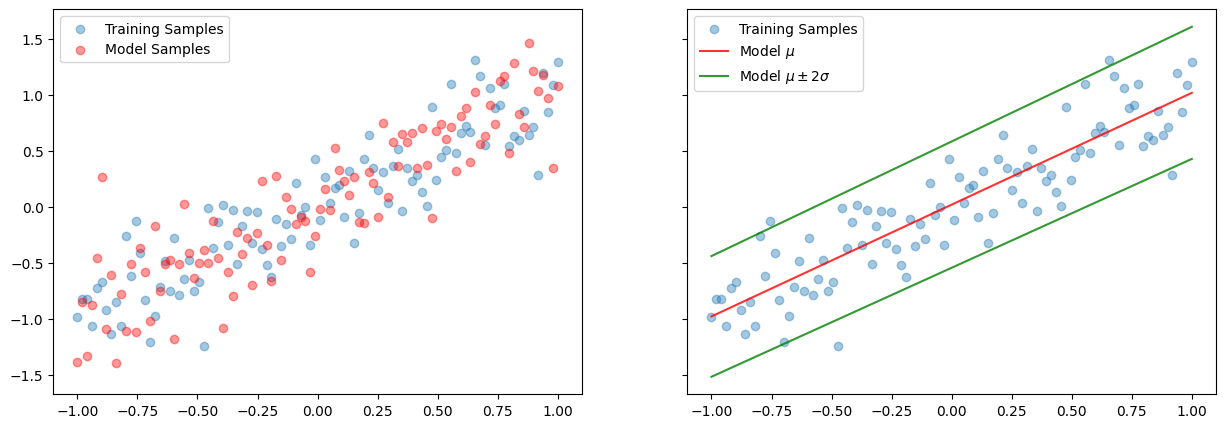

In [26]:
# Plot the data and a sample from the model
y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='Training Samples')
ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='Model Samples')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='Training Samples')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='Model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='Model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

#### Probabilistic linear regression with nonlinear learned mean & variance

Let's change the data to being nonlinear:
$$ y_i = x_i^3 + \frac{1}{10}(2 + x_i)\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

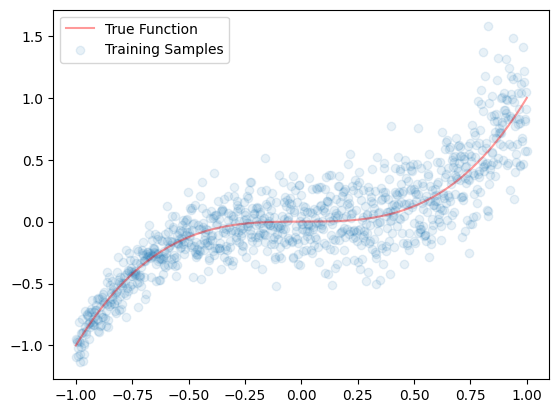

In [27]:
# Create and plot 10000 data points
x_train = np.float32(np.linspace(-1, 1, 1000)[:, np.newaxis])
y_train = np.power(x_train, 3) + 0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.plot(x_train, np.power(x_train, 3), color='red', alpha=0.4, label='True Function')
plt.scatter(x_train, y_train, alpha=0.1, label='Training Samples')
plt.legend()
plt.show()

In [28]:
# Create probabilistic regression: normal distribution with fixed variance
model = Sequential([
    Dense(input_shape=(1,), units=8, activation='sigmoid'),
    Dense(tfpl.IndependentNormal.params_size(event_shape=1)),
    tfpl.IndependentNormal(event_shape=1)
])

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 8)                 16        
                                                                 
 dense_8 (Dense)             (None, 2)                 18        
                                                                 
 independent_normal_1 (Indep  ((None, 1),              0         
 endentNormal)                (None, 1))                         
                                                                 
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Train model
model.fit(x_train, y_train, epochs=200, verbose=False)
model.evaluate(x_train, y_train)

32/32 [==============================] - 0s 2ms/step - loss: -0.0081


-0.008129112422466278

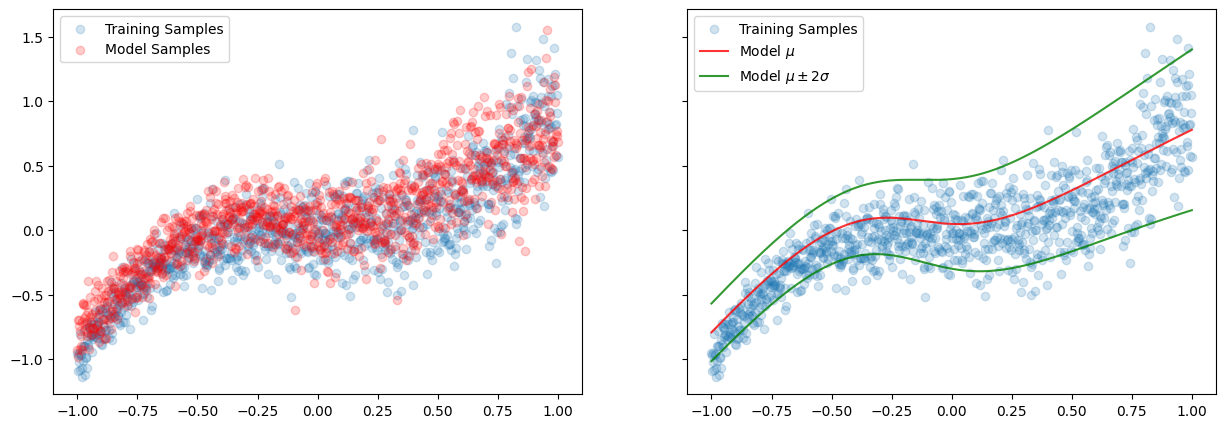

In [30]:
# Plot the data and a sample from the model
y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.2, label='Training Samples')
ax1.scatter(x_train, y_sample, alpha=0.2, color='red', label='Model Samples')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.2, label='Training Samples')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='Model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='Model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

***
<a id="coding_tutorial_3"></a>
## The `DenseVariational` layer

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#### Create linear data with Gaussian noise

The data you'll be working with is the same as you used before:
$$ y_i = x_i + \frac{3}{10}\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed. We'll be running a Bayesian linear regression on this data.

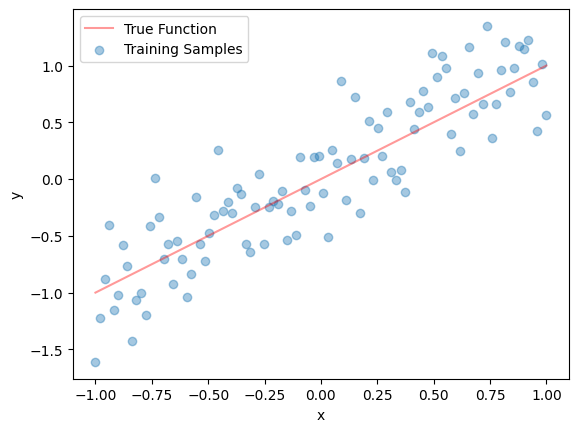

In [32]:
# Create the same data as before -- create and plot 100 data points
x_train = np.float32(np.linspace(-1, 1, 100)[:, np.newaxis])
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]

plt.plot(x_train, x_train, color='red', alpha=0.4, label='True Function')
plt.scatter(x_train, y_train, alpha=0.4, label='Training Samples')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Create the prior and posterior distribution for model weights

In [33]:
# Define the prior parameter distribution -- non-trainable standard multivariate Gaussian i.e. N(0, I)
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size # number of model parameters
    prior_model = Sequential([
        tfpl.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n))), # returns standard multivariate Gaussian
    ])
    return prior_model

In [34]:
# Define variational posterior parameter distribution -- trainable multivariate Gaussian
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size # number of model parameters
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype), # returns a (trainable) variable, regardless of input using a lower triangular multivariate Gaussian with full covariance
        tfpl.MultivariateNormalTriL(n) # returns lower triangular multivariate Gaussian distribution object
    ])
    return posterior_model

#### Aside: analytical posterior

In this tutorial, we're using a variational posterior because, in most settings, it's not possible to derive an analytical one. However, in this simple setting, it is possible. Specifically, running a Bayesian linear regression on $x_i$ and $y_i$ with $i=1, \ldots, n$ and a unit Gaussian prior on both $\alpha$ and $\beta$:

$$
y_i = \alpha + \beta x_i + \epsilon_i, \quad 
\epsilon_i \sim N(0, \sigma^2), \quad 
\alpha \sim N(0, 1), \quad 
\beta \sim N(0, 1)
$$

gives a multivariate Gaussian posterior on $\alpha$ and $\beta$:

$$
\begin{pmatrix}
\alpha \\
\beta
\end{pmatrix}
\sim
N(\mathbf{\mu}, \mathbf{\Sigma})
$$
where
$$ 
\mathbf{\mu}
= 
\mathbf{\Sigma} 
\begin{pmatrix}
\hat{n} \bar{y} \\
\hat{n} \overline{xy}
\end{pmatrix},
\quad
\mathbf{\Sigma} = 
\frac{1}{(\hat{n} + 1)(\hat{n} \overline{x^2} + 1) - \hat{n}^2 \bar{x}^2}
\begin{pmatrix}
\hat{n} \overline{x^2} + 1 & -\hat{n} \bar{x} \\
-\hat{n} \bar{x} & \hat{n} + 1
\end{pmatrix}.
$$

In the above, $\hat{n} = \frac{n}{\sigma^2}$ and $\bar{t} = \frac{1}{n}\sum_{i=1}^n t_i$ for any $t$. In general, however, it's not possible to determine the analytical form for the posterior. For example, in models with a hidden layer with nonlinear activation function, the analytical posterior cannot be determined in general, and variational methods as below are useful.

#### Create the model with `DenseVariational` layers

In [35]:
# Create linear regression model with weight uncertainty: weights are distributed according to posterior (and, indirectly, prior) distribution
model = Sequential([
    tfpl.DenseVariational(input_shape=(1, ), # single input
                          units=1, # single output
                          make_prior_fn=prior, # prior function
                          make_posterior_fn=posterior, # posterior function
                          kl_weight=1/x_train.shape[0], # KLD weight for correct scaling
                          kl_use_exact=True), # use exact KLD since TensorFlow Probability knows the exact analytical solution of KLD between above defined variational posterior and prior multivariate Gaussians
])

model.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model.summary()

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational (DenseVar  (None, 1)                5         
 iational)                                                       
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


Let's discuss quickly, why this model has five parameters. So, regular deterministic linear regression model has just two parameters. It has the slope (weight) and the y-intercept (bias), so why/how does this model have five?

Recall that the whole point of the dense variational layer is to replace each model parameter by a distribution and learn the parameters of that distribution. So these are the number of parameters of the distribution that describe this model. What are they?

Well, we still have means and variances for the y-intercept (bias) and the slope (weight) but now there's some covariance as well. So, we have `2` means for y-intercept and slope respectively, `2` variances for y-intercept and slope respectively, and `1` covariance between them, so that's `5` in total.

#### Train model and inspect

In [36]:
# Fit the model, just like a deterministic linear regression
model.fit(x_train, y_train, epochs=500, verbose=False)

In [37]:
# Check out the parameters of the prior and posterior distribution
dummy_input = np.array([[0]])
model_prior = model.layers[0]._prior(dummy_input)
model_posterior = model.layers[0]._posterior(dummy_input)
print('Prior Mean:           ', model_prior.mean().numpy())
print('Prior Variance:       ', model_prior.variance().numpy())
print('Posterior Mean:       ', model_posterior.mean().numpy())
print('Posterior Covariance: ', model_posterior.covariance().numpy()[0])
print('                      ', model_posterior.covariance().numpy()[1])

Prior Mean:            [0. 0.]
Prior Variance:        [1. 1.]
Posterior Mean:        [1.044885   0.03399968]
Posterior Covariance:  [0.01973645 0.00256703]
                       [0.00256703 0.00594349]


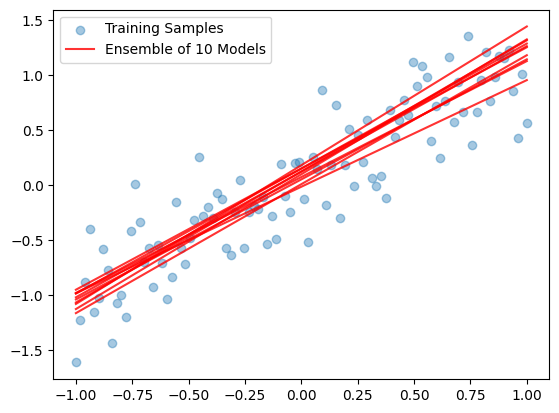

In [38]:
# Plot an ensemble of 10 linear regressions, with parameters sampled from the posterior distribution
plt.scatter(x_train, y_train, alpha=0.4, label='Training Samples')
for _ in range(10):
    y_model = model(x_train)
    if _ == 0:
        plt.plot(x_train, y_model, color='red', alpha=0.8, label='Ensemble of 10 Models')
    else:
        plt.plot(x_train, y_model, color='red', alpha=0.8)        
plt.legend()
plt.show()

#### Explore the effect of sample size

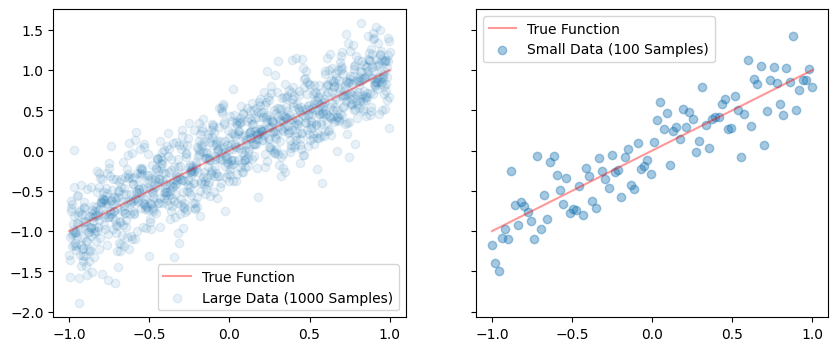

In [39]:
# Create two datasets, one with 1000 points, another with 100
x_train_1000 = np.float32(np.linspace(-1, 1, 1000)[:, np.newaxis])
y_train_1000 = x_train_1000 + 0.3*np.random.randn(1000)[:, np.newaxis]

x_train_100 = np.float32(np.linspace(-1, 1, 100)[:, np.newaxis])
y_train_100 = x_train_100 + 0.3*np.random.randn(100)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
ax1.plot(x_train_1000, x_train_1000, color='red', alpha=0.4, label='True Function')
ax1.scatter(x_train_1000, y_train_1000, alpha=0.1, label='Large Data (1000 Samples)')
ax2.plot(x_train_100, x_train_100, color='red', alpha=0.4, label='True Function')
ax2.scatter(x_train_100, y_train_100, alpha=0.4, label='Small Data (100 Samples)')
ax1.legend()
ax2.legend()
plt.show()

In [40]:
# Train a model on each dataset
model_1000 = Sequential([tfpl.DenseVariational(input_shape=(1,), 
                                               units=1,
                                               make_prior_fn=prior, 
                                               make_posterior_fn=posterior,
                                               kl_weight=1/1000)])

model_100 = Sequential([tfpl.DenseVariational(input_shape=(1,), 
                                              units=1,
                                              make_prior_fn=prior, 
                                              make_posterior_fn=posterior,
                                              kl_weight=1/100)])

model_1000.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model_100.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))

model_1000.fit(x_train_1000, y_train_1000, epochs=50, verbose=False)
model_100.fit(x_train_100, y_train_100, epochs=500, verbose=False)

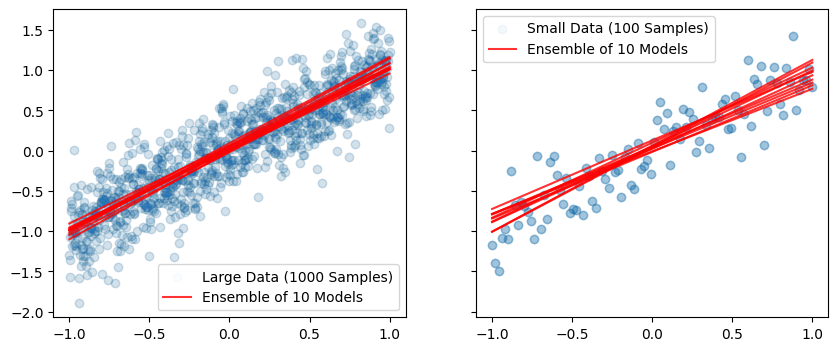

In [41]:
# Plot an ensemble of linear regressions from each model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for _ in range(10):
    
    y_model_1000 = model_1000(x_train_1000)
    if _ == 0:
        ax1.scatter(x_train_1000, y_train_1000, color='C0', alpha=0.02, label='Large Data (1000 Samples)')
        ax1.plot(x_train_1000, y_model_1000, color='red', alpha=0.8, label='Ensemble of 10 Models')
    else:
        ax1.scatter(x_train_1000, y_train_1000, color='C0', alpha=0.02)
        ax1.plot(x_train_1000, y_model_1000, color='red', alpha=0.8)

    y_model_100 = model_100(x_train_100)
    if _ == 0:
        ax2.scatter(x_train_100, y_train_100, color='C0', alpha=0.05, label='Small Data (100 Samples)')
        ax2.plot(x_train_100, y_model_100, color='red', alpha=0.8, label='Ensemble of 10 Models')
    else:
        ax2.scatter(x_train_100, y_train_100, color='C0', alpha=0.05)
        ax2.plot(x_train_100, y_model_100, color='red', alpha=0.8)

ax1.legend()
ax2.legend()
plt.show()

#### Put it all together: nonlinear probabilistic regression with weight uncertainty

Let's begin with linear data

In [42]:
# Train a model on each dataset
model_1000 = Sequential([
    # epistemic uncertainty quantification
    tfpl.DenseVariational(units=1,
                          input_shape=(1,),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0],
                          activation=None),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0]),
    # aleatoric uncertainty quantification
    tfpl.IndependentNormal(1)
])

model_100 = Sequential([
    # epistemic uncertainty quantification
    tfpl.DenseVariational(units=1,
                          input_shape=(1,),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0],
                          activation=None),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0]),
    # aleatoric uncertainty quantification
    tfpl.IndependentNormal(1)
])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model_1000.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model_100.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))

model_1000.fit(x_train_1000, y_train_1000, epochs=50, verbose=False)
model_100.fit(x_train_100, y_train_100, epochs=500, verbose=False)

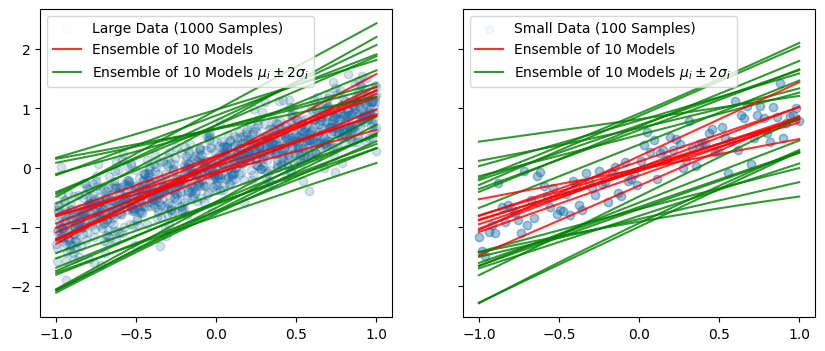

In [43]:
# Plot an ensemble of linear regressions from each model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for _ in range(10):

    y_model_1000 = model_1000(x_train_1000)
    y_hat_1000 = y_model_1000.mean()
    y_1000_m2sd = y_hat_1000 - 2 * y_model_1000.stddev()
    y_1000_p2sd = y_hat_1000 + 2 * y_model_1000.stddev()
    if _ == 0:
        ax1.scatter(x_train_1000, y_train_1000, color='C0', alpha=0.02, label='Large Data (1000 Samples)')
        ax1.plot(x_train_1000, y_hat_1000, color='red', alpha=0.8, label='Ensemble of 10 Models')
        ax1.plot(x_train_1000, y_1000_m2sd, color='green', alpha=0.8, label='Ensemble of 10 Models $\mu_i \pm 2 \sigma_i$')
        ax1.plot(x_train_1000, y_1000_p2sd, color='green', alpha=0.8)
    else:
        ax1.scatter(x_train_1000, y_train_1000, color='C0', alpha=0.02)
        ax1.plot(x_train_1000, y_hat_1000, color='red', alpha=0.8)
        ax1.plot(x_train_1000, y_1000_m2sd, color='green', alpha=0.8)
        ax1.plot(x_train_1000, y_1000_p2sd, color='green', alpha=0.8)

    y_model_100 = model_100(x_train_100)
    y_hat_100 = y_model_100.mean()
    y_100_m2sd = y_hat_100 - 2 * y_model_100.stddev()
    y_100_p2sd = y_hat_100 + 2 * y_model_100.stddev()
    if _ == 0:
        ax2.scatter(x_train_100, y_train_100, color='C0', alpha=0.05, label='Small Data (100 Samples)')
        ax2.plot(x_train_100, y_hat_100, color='red', alpha=0.8, label='Ensemble of 10 Models')
        ax2.plot(x_train_100, y_100_m2sd, color='green', alpha=0.8, label='Ensemble of 10 Models $\mu_i \pm 2 \sigma_i$')
        ax2.plot(x_train_100, y_100_p2sd, color='green', alpha=0.8)
    else:
        ax2.scatter(x_train_100, y_train_100, color='C0', alpha=0.05)
        ax2.plot(x_train_100, y_hat_100, color='red', alpha=0.8)
        ax2.plot(x_train_100, y_100_m2sd, color='green', alpha=0.8)
        ax2.plot(x_train_100, y_100_p2sd, color='green', alpha=0.8)

ax1.legend()
ax2.legend()
plt.show()

Let's change the data to being nonlinear:
$$ y_i = x_i^3 + \frac{1}{10}(2 + x_i)\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

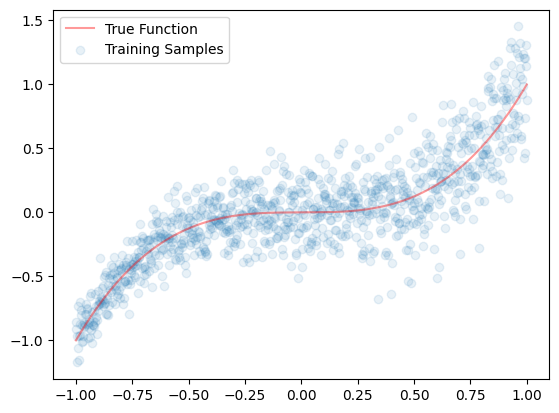

In [44]:
# Create the same data as before -- create and plot 1000 data points
x_train = np.float32(np.linspace(-1, 1, 1000)[:, np.newaxis])
y_train = np.power(x_train, 3) + 0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.plot(x_train, np.power(x_train, 3), color='red', alpha=0.4, label='True Function')
plt.scatter(x_train, y_train, alpha=0.1, label='Training Samples')
plt.legend()
plt.show()

In [45]:
# Create probabilistic regression with one hidden layer, weight uncertainty
model = Sequential([
    # epistemic uncertainty quantification
    tfpl.DenseVariational(units=8,
                          input_shape=(1,),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0],
                          activation='sigmoid'),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0]),
    # aleatoric uncertainty quantification
    tfpl.IndependentNormal(1)
])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational_7 (DenseV  (None, 8)                152       
 ariational)                                                     
                                                                 
 dense_variational_8 (DenseV  (None, 2)                189       
 ariational)                                                     
                                                                 
 independent_normal_4 (Indep  ((None, 1),              0         
 endentNormal)                (None, 1))                         
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Train the model
model.fit(x_train, y_train, epochs=1000, verbose=False)
model.evaluate(x_train, y_train)

32/32 [==============================] - 1s 5ms/step - loss: 0.0294


0.02935086004436016

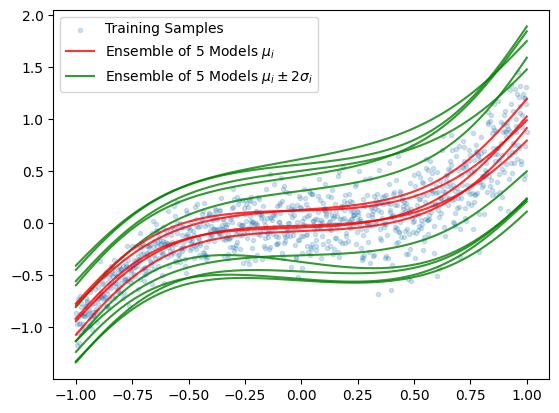

In [47]:
# Plot an ensemble of trained probabilistic regressions
plt.scatter(x_train, y_train, marker='.', alpha=0.2, label='Training Samples')
for _ in range(5):
    y_model = model(x_train)
    y_hat = y_model.mean()
    y_hat_m2sd = y_hat - 2 * y_model.stddev()
    y_hat_p2sd = y_hat + 2 * y_model.stddev()
    if _ == 0:
        plt.plot(x_train, y_hat, color='red', alpha=0.8, label='Ensemble of 5 Models $\mu_i$')
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='Ensemble of 5 Models $\mu_i \pm 2 \sigma_i$')
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
    else:
        plt.plot(x_train, y_hat, color='red', alpha=0.8)
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8)
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)        
plt.legend()
plt.show()

***
<a id="coding_tutorial_4"></a>
## Reparameterization layers

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop
import os
import numpy as np
import matplotlib.pyplot as plt

#### Load in the HAR dataset

You'll be working with the [Human Activity Recognition (HAR) Using Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. It consists of the readings from an accelerometer (which measures acceleration) carried by a human doing different activities. The six activities are walking horizontally, walking upstairs, walking downstairs, sitting, standing and laying down. The accelerometer is inside a smartphone, and, every 0.02 seconds (50 times per second), it takes six readings: linear and gyroscopic acceleration in the x, y and z directions. See [this link](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) for details and download. If you use it in your own research, please cite the following paper:

- Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013. 

The goal is to use the accelerometer data to predict the activity.

In [3]:
# Load the HAR dataset and create some data processing functions

# Function to load the data from file
def load_HAR_data():
    data_dir = 'Data/'
    x_train = np.load(os.path.join(data_dir, 'x_train.npy'))[..., :6]
    y_train = np.load(os.path.join(data_dir, 'y_train.npy')) - 1
    x_test  = np.load(os.path.join(data_dir, 'x_test.npy'))[..., :6]
    y_test  = np.load(os.path.join(data_dir, 'y_test.npy')) - 1
    return (x_train, y_train), (x_test, y_test)

# Dictionary containing the labels and the associated activities
label_to_activity = {0: 'walking horizontally', 1: 'walking upstairs', 2: 'walking downstairs',
                     3: 'sitting', 4: 'standing', 5: 'laying'}

# Function to change integer labels to one-hot labels
def integer_to_onehot(data_integer):
    data_onehot = np.zeros(shape=(data_integer.shape[0], data_integer.max()+1))
    for row in range(data_integer.shape[0]):
        integer = int(data_integer[row])
        data_onehot[row, integer] = 1
    return data_onehot

# Load the data
(x_train, y_train), (x_test, y_test) = load_HAR_data()
y_train_oh = integer_to_onehot(y_train)
y_test_oh = integer_to_onehot(y_test)

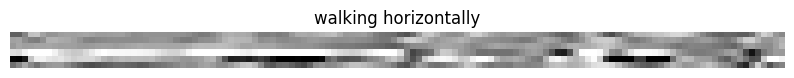

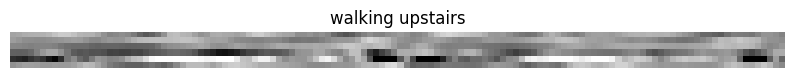

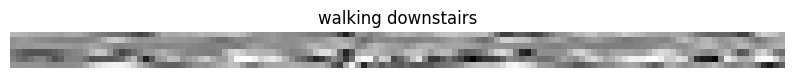

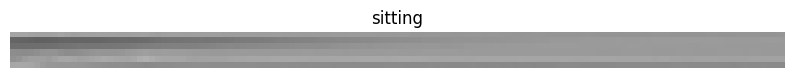

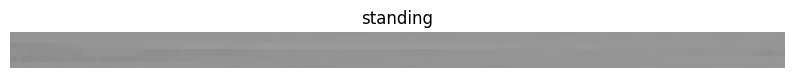

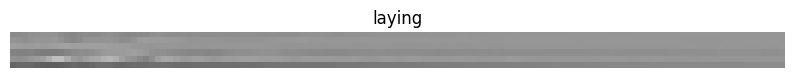

In [4]:
# Inspect some of the data by making plots
def make_plots(num_examples_per_category):
    for label in range(6):
        x_label = x_train[y_train[:, 0] == label]
        for i in range(num_examples_per_category):
            fig, ax = plt.subplots(figsize=(10, 1))
            ax.imshow(x_label[100*i].T, cmap='Greys', vmin=-1, vmax=1)
            ax.axis('off')
            if i == 0:
                ax.set_title(label_to_activity[label])
            plt.show()
        
make_plots(1)

So, each of these data points, it's kind of like 6 x 128 px image. There's six on the y axis, and these are the six readings from the accelerometer (the accelerations in different directions/axes), and then on the x axis, there's time (128 time steps). Our goal is going to be to take one of these acceleration readings and predict the activity, and so the way we're going to do it is by using convolutional neural networks (CNNs).

Now, although one might think we'll be using 2D CNN for this problem because the input looks like a 2D image, note that actually we'll be using 1D CNN model. If you recall from doing convolutions on colored images that there's also a 3rd dimension, the channels (e.g. 3 for R, G, B). Similarly, for this problem, we're going to view the input image as having 1 dimension (i.e. the time steps) and 6 channels (i.e. each of the acceleration readings counts as one channel).

#### 1D deterministic convolutional neural network

In [5]:
# Create standard deterministic model with:
# - Conv1D
# - MaxPooling
# - Flatten
# - Dense with Softmax

model = Sequential([
    Conv1D(input_shape=(128, 6), filters=8, kernel_size=16, activation='relu'),
    MaxPooling1D(pool_size=16),
    Flatten(),
    Dense(units=6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 113, 8)            776       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 8)             0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 56)                0         
                                                                 
 dense (Dense)               (None, 6)                 342       
                                                                 
Total params: 1,118
Trainable params: 1,118
Non-trainable params: 0
_________________________________________________________________


#### Probabilistic 1D convolutional neural network, with both weight and output uncertainty

In [8]:
# Create probablistic model with the following layers:
#  - Conv1D
#  - MaxPooling
#  - Flatten
#  - Dense
#  - OneHotCategorical

divergence_fn = lambda q, p, _: tfd.kl_divergence(q, p) / x_train.shape[0] # divergence function with exact solution to KLD between posterior q and prior p scaled appropriately

model = Sequential([
    tfpl.Convolution1DReparameterization( # probabilistic variant of 1D convolution layer
        input_shape=(128, 6), filters=8, kernel_size=16, activation='relu', # similar 1D convolution as before
        kernel_prior_fn=tfpl.default_multivariate_normal_fn, # non-trainable default multivariate normal distribution
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False), # trainable default multivariate normal distribution (with variational posterior using mean-field approximation)
        kernel_divergence_fn=divergence_fn,
        bias_prior_fn=tfpl.default_multivariate_normal_fn, # non-trainable default multivariate normal distribution
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False), # trainable default multivariate normal distribution (with variational posterior using mean-field approximation)
        bias_divergence_fn=divergence_fn
    ),
    MaxPooling1D(pool_size=16), # similar 1D max. pooling layer as before
    Flatten(), # similar flatten layer as before
    tfpl.DenseReparameterization( # probabilistic variant of dense layer
        units=tfpl.OneHotCategorical.params_size(6),
        activation=None,
        kernel_prior_fn=tfpl.default_multivariate_normal_fn, # non-trainable default multivariate normal distribution
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False), # trainable default multivariate normal distribution (with variational posterior using mean-field approximation)
        kernel_divergence_fn=divergence_fn,
        bias_prior_fn=tfpl.default_multivariate_normal_fn, # non-trainable default multivariate normal distribution
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False), # trainable default multivariate normal distribution (with variational posterior using mean-field approximation)
        bias_divergence_fn=divergence_fn
    ),
    tfpl.OneHotCategorical(6) # one-hot encoded categorical layer with 6 outputs (categories)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_reparameterization (  (None, 113, 8)           1552      
 Conv1DReparameterization)                                       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 8)             0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 56)                0         
                                                                 
 dense_reparameterization (D  (None, 6)                684       
 enseReparameterization)                                         
                                                                 
 one_hot_categorical (OneHot  ((None, 6),              0         
 Categorical)                 (None, 6))              

c:\Users\csamak\AppData\Local\anaconda3\envs\nigel_vd_bnn\lib\site-packages\tensorflow_probability\python\layers\util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
c:\Users\csamak\AppData\Local\anaconda3\envs\nigel_vd_bnn\lib\site-packages\tensorflow_probability\python\layers\util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [9]:
# Replace analytical Kullback-Leibler (KL) divergence with approximated one (Monte Carlo approximation) in previous cell to observe the difference(s)
def kl_approx(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))

divergence_fn = lambda q, p, q_tensor : kl_approx(q, p, q_tensor) / x_train.shape[0]

In [10]:
# Compile the model using the negative loglikelihood
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll,
              optimizer=RMSprop(learning_rate=0.005),
              metrics=['accuracy'],
              experimental_run_tf_function=False) # argument required to use reparameterization layers

In [11]:
# Train the model
model.fit(x_train, y_train_oh, epochs=20, verbose=False)
model.evaluate(x_train, y_train_oh)
model.evaluate(x_test, y_test_oh)

: 

: 

#### Inspect model performance

In [ ]:
# Define function to analyse model predictions versus true labels
def analyse_model_predictions(image_num):

    # Show the accelerometer data
    print('------------------------------')
    print('Accelerometer Data:')
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow(x_test[image_num].T, cmap='Greys', vmin=-1, vmax=1)
    ax.axis('off')
    plt.show()

    # Print the true activity
    print('------------------------------')
    print('True Activity Label:', label_to_activity[y_test[image_num, 0]])
    print('')

    # Print the probabilities the model assigns
    print('------------------------------')
    print('Model Estimated Activity Probabilities:')
    # Create ensemble of predicted probabilities
    predicted_probabilities = np.empty(shape=(200, 6))
    for i in range(200):
        predicted_probabilities[i] = model(x_test[image_num][np.newaxis, ...]).mean().numpy()[0]
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(6)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(6)])
    # Make the plots
    fig, ax = plt.subplots(figsize=(9, 3))
    bar = ax.bar(np.arange(6), pct_97p5, color='red')
    bar[y_test[image_num, 0]].set_color('green')
    bar = ax.bar(np.arange(6), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],
                       rotation=45, horizontalalignment='right')
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

Below, for every sample input, we can see the `true accelerometer data` (image), the `true activity` (e.g. walking horizontally), and a `plot` of probability vs. activity. Let's see what this plot means.

So, what this plot shows, is both the aleatoric and the epistemic uncertainties. The way it shows the aleatoric uncertainty is that it shows the probability over different activities, over what it thinks, this data corresponds to. And the way it shows the epistemic uncertainty is actually by running ensemble model predictions 200 times (sampling new weights every time) and using that to create a 95% confidance interval (CI) for the prediction probability.

Note that in probability and statistics, the 97.5th percentile point of the standard normal distribution is a number commonly used for statistical calculations. The approximate value of this number is 1.96, meaning that 95% of the area under the normal curve lies within approximately 1.96 standard deviations of the mean.

------------------------------
Accelerometer Data:


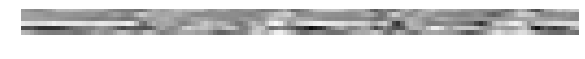

------------------------------
True Activity Label: walking horizontally

------------------------------
Model Estimated Activity Probabilities:


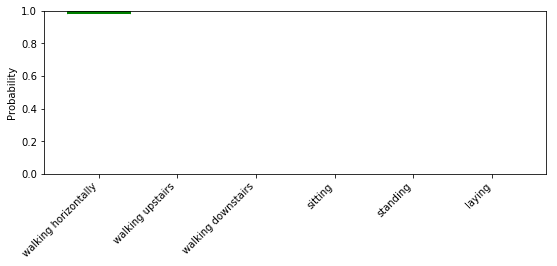

In [ ]:
analyse_model_predictions(image_num=79) # run prediction on 80th input

Above is an example of very crisp (predicted just 1 class indicating low aleatoric uncertainty) and very certain (predicted the same probability 200 times indicating low epistemic uncertainty) prediction.

------------------------------
Accelerometer Data:


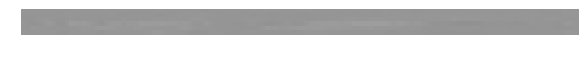

------------------------------
True Activity Label: standing

------------------------------
Model Estimated Activity Probabilities:


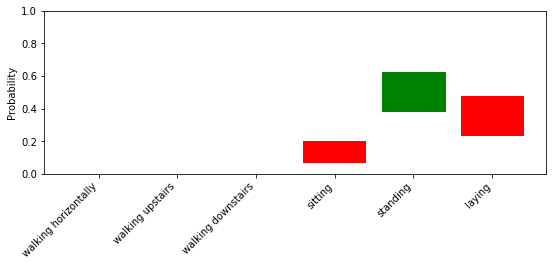

In [ ]:
analyse_model_predictions(image_num=633) # run prediction on 80th input

Above is an example of not-so crisp (indicating high aleatoric uncertainty) and not-so certain (indicating high epistemic uncertainty) prediction.

------------------------------
Accelerometer Data:


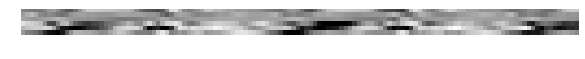

------------------------------
True Activity Label: walking horizontally

------------------------------
Model Estimated Activity Probabilities:


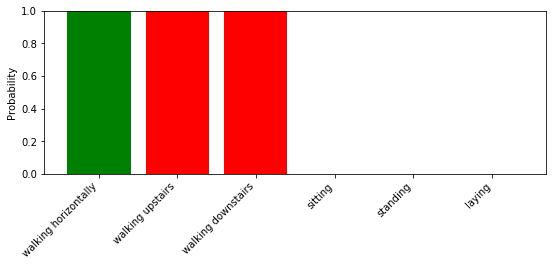

In [ ]:
analyse_model_predictions(image_num=1137) # run prediction on 80th input

Above is an example of not-so crisp (indicating high aleatoric uncertainty) and not-at-all certain (indicating high epistemic uncertainty) prediction.